In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#default_exp callback.cutmix

In [ ]:
#export
from torch.distributions.beta import Beta
from fastai.vision.all import *

# CutMix Callback
> Callback to apply [CutMix](https://arxiv.org/pdf/1905.04899.pdf) data augmentation technique to the training data.

From the [research paper](https://arxiv.org/pdf/1905.04899.pdf), `CutMix` is a way to combine two images. It comes from `MixUp` and `Cutout`. In this data augmentation technique:
> patches are cut and pasted among training images where the ground truth labels are also mixed proportionally to the area of the patches

Also, from the paper: 
> By making efficient use of training pixels and retaining the regularization effect of regional dropout, CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly-supervised localization task. Moreover, unlike previous augmentation methods, our CutMix-trained ImageNet classifier, when used as a pretrained model, results in consistent performance gains in Pascal detection and MS-COCO image captioning benchmarks. We also show that CutMix improves the model robustness against input corruptions and its out-of-distribution detection performances. 

In [ ]:
#export
class CutMix(Callback):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

## How does the batch with `CutMix` data augmentation technique look like?

First, let's quickly create the `dls` using `ImageDataLoaders.from_name_re` DataBlocks API.

In [ ]:
path = untar_data(URLs.PETS)
pat        = r'([^/]+)_\d+.*$'
fnames     = get_image_files(path/'images')
item_tfms  = [Resize(256, method='crop')]
batch_tfms = [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=64, item_tfms=item_tfms, 
                                    batch_tfms=batch_tfms)

Next, let's initialize the callback `CutMix`, create a learner, do one batch and display the images with the labels. `CutMix` inside updates the loss function based on the ratio of the cutout bbox to the complete image.

In [ ]:
cutmix = CutMix(alpha=1.)

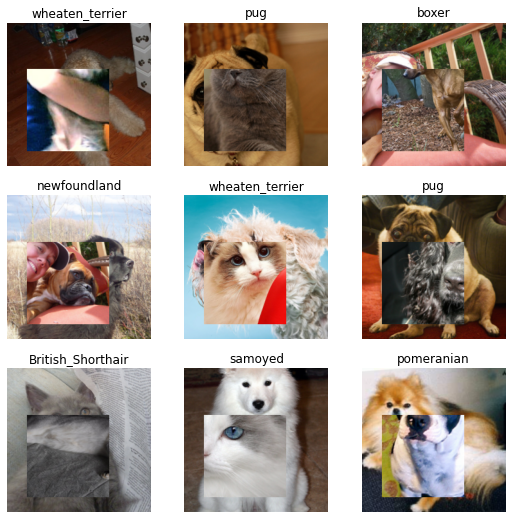

In [ ]:
with Learner(dls, resnet18(), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

## Using `CutMix` in Training

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), cbs=cutmix, metrics=[accuracy, error_rate])
# learn.fit_one_cycle(1)


## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.l